## Classificador binário para características morfométricas de núcleo/citoplasma de células cervicais 

In [88]:
import numpy as np
import pandas as pd 
from math import sqrt
import os
import sys
import csv
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis

import pyefd
from pyefd import elliptic_fourier_descriptors, normalize_efd

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import feature_selection as fs

from datetime import datetime

# pay attention to capitalization below!
from spFSR import SpFSR
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE

from itertools import cycle
from random import randint
from random import sample

import xgboost as xgb 


In [2]:
Bethesda_classes = {'Normal':0, 'ASC-US':1, 'ASC-H':2, 'LSIL':3,'HSIL':4, 'Invasive Carcinoma':5} 
Bethesda_idx_classes = {0: 'Normal', 1:'ASC-US', 2:'ASC-H', 3:'LSIL',4: 'HSIL', 5:'Invasive Carcinoma'} 

### Funções para listar features:

In [3]:
def list_all_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C
     
   feature_labels=['areaN', 'eccenN', 'extentN', 'periN', 'maxAxN', 'minAxN',
                   'compacN', 'circuN', 'convexN', 'hAreaN', 'solidN', 'equidiaN', 
                   'elonN', 'sdnrlN', 'raN', 'riN', 'eN', 'kN', 'mrdN', 'ardN', 'fdN'] 
   
   efdNs = ['efdN'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdNs:
       feature_labels.append(name_f) 
   
   aux=['areaC', 'eccenC', 'extentC', 'periC', 'maxAxC', 'minAxC',
         'compacC', 'circuC', 'convexC', 'hAreaC', 'solidC', 'equidiaC', 
          'elonC', 'sdnrlC', 'raC', 'riC', 'eC', 'kC', 'mrdC', 'ardC', 'fdC'] 
   for name_f in aux:
       feature_labels.append(name_f)

   efdCs = ['efdC'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdCs:
       feature_labels.append(name_f)
    
   aux = ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'nucleus_position']

   for name_f in aux:
       feature_labels.append(name_f)
   return feature_labels   

def list_all_EFD_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C

   feature_labels = ['efdN'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]      
   efdCs = ['efdC'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdCs:
       feature_labels.append(name_f)
   return feature_labels   


def list_all_nucleus_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C
     
   feature_labels=['areaN', 'eccenN', 'extentN', 'periN', 'maxAxN', 'minAxN',
                   'compacN', 'circuN', 'convexN', 'hAreaN', 'solidN', 'equidiaN', 
                   'elonN', 'sdnrlN', 'raN', 'riN', 'eN', 'kN', 'mrdN', 'ardN', 'fdN'] 
   
   efdNs = ['efdN'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdNs:
       feature_labels.append(name_f) 
    
   #TODO: incluir features abaixo? 
   #aux = ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'nucleus_position']
   #for name_f in aux:
   #    feature_labels.append(name_f)

   return feature_labels   

def list_all_cyto_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C
     
   feature_labels =['areaC', 'eccenC', 'extentC', 'periC', 'maxAxC', 'minAxC',
         'compacC', 'circuC', 'convexC', 'hAreaC', 'solidC', 'equidiaC', 
          'elonC', 'sdnrlC', 'raC', 'riC', 'eC', 'kC', 'mrdC', 'ardC', 'fdC'] 

   efdCs = ['efdC'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdCs:
       feature_labels.append(name_f)
    
   #aux = ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'nucleus_position']
   #for name_f in aux:
   #    feature_labels.append(name_f)
    
   return feature_labels   

In [4]:
len(list_all_features(20)), len(list_all_nucleus_features(20)), len(list_all_cyto_features(20)), len(list_all_EFD_features(20))

(200, 98, 98, 154)

### Funções para normalizar (todos os dados)

In [5]:
## Normaliza dados
def normalize(min, max, value):
    return (value-min)/(max - min)

def normalize_prop(prop, df):
    min = np.min(df[prop].values)
    max = np.max(df[prop].values)
    return (normalize(min, max, df[prop].values))

# Filtra/normaliza dados
def normalize_dataset(df, n_efd_coeffs):
  dataset = df.copy()
   
  dataset.areaN = normalize_prop('areaN', df)
  dataset.eccenN = normalize_prop('eccenN', df) 
  dataset.extentN = normalize_prop('extentN', df)
  dataset.periN = normalize_prop('periN', df)
  dataset.maxAxN = normalize_prop('maxAxN', df)  
  dataset.minAxN = normalize_prop('minAxN', df)  
  dataset.compacN = normalize_prop('compacN', df)
  dataset.circuN = normalize_prop('circuN', df)
  dataset.convexN = normalize_prop('convexN', df)
  dataset.hAreaN = normalize_prop('hAreaN', df)
  dataset.solidN = normalize_prop('solidN', df) 
  dataset.equidiaN = normalize_prop('equidiaN', df) 
  dataset.elonN = normalize_prop('elonN', df)
  dataset.eN = normalize_prop('eN', df)  
  dataset.kN = normalize_prop('kN', df)  
  dataset.mrdN = normalize_prop('mrdN', df)  
  dataset.ardN = normalize_prop('ardN', df)  
  dataset.fdN = normalize_prop('fdN', df)       
  efds = ['efdN'+str(i) for i in range(1,(n_efd_coeffs*4 + 1 - 3))]
  for efd in efds: 
      dataset[efd] = normalize_prop(efd, df) 
    
  dataset.areaC = normalize_prop('areaC', df)
  dataset.eccenC = normalize_prop('eccenC', df) 
  dataset.extentC = normalize_prop('extentC', df)
  dataset.periC = normalize_prop('periC', df)
  dataset.maxAxC = normalize_prop('maxAxC', df)  
  dataset.minAxC = normalize_prop('minAxC', df)
  dataset.compacC = normalize_prop('compacC', df)
  dataset.circuC = normalize_prop('circuC', df)
  dataset.convexC = normalize_prop('convexC', df)
  dataset.hAreaC = normalize_prop('hAreaC', df)
  dataset.solidC = normalize_prop('solidC', df) 
  dataset.equidiaC = normalize_prop('equidiaC', df) 
  dataset.elonC = normalize_prop('elonC', df)
  dataset.eC = normalize_prop('eC', df)  
  dataset.kC = normalize_prop('kC', df)  
  dataset.mrdC = normalize_prop('mrdC', df)  
  dataset.ardC = normalize_prop('ardC', df)  
  dataset.fdC = normalize_prop('fdC', df)       
  efds = ['efdC'+str(i) for i in range(1,(n_efd_coeffs*4 + 1 - 3))]
  for efd in efds: 
      dataset[efd] = normalize_prop(efd, df)   

  #dataset.nucleus_position = normalize_prop('nucleus_position', df)
 
  return dataset

 ###  Funções - organiza dados (x, y, ids) e filtra base para diferentes classificadores:

In [6]:
 #Monta base e retorna 3 dataframes: data (x), target(2,3 e 6 classes), image/cell_id
def get_database_data_targe_ids(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       features_to_fit):
 
    data =  pd.DataFrame(data=np.vstack([
                          data_normal.values,
                          data_ascus.values,
                          data_asch.values,
                          data_lsil.values, 
                          data_hsil.values,
                          data_car.values]), 
                         columns = data_car.columns)
    
    ## ID's imagens e celulas
    image_cells_ids= data[['image_id', 'cell_id']].copy() 
    
    ##Ajusta y(target) para classificação binária, ternária além de bethesda
    y = np.array(data['bethesda'].values)
    y_bin = np.array(y)
    y_ter = np.array(y)
        
    for i in range(data.shape[0]):
         y_bin[i] = 0 if y_bin[i]==0 else 1
    
    for i in range(data.shape[0]):
          if y_ter[i] == 3:  ##Lsil
             y_ter[i] = 1
          elif (y_ter[i] == 4 or y_ter[i] == 5):  ##HSIl e Car
                y_ter[i] = 2
                
    target = pd.DataFrame(data = np.stack([y_bin,
                                           y_ter,
                                           y], axis=-1),
                          columns = ['binary', 'ternary', 'bethesda'])
    
    data = data[features_to_fit]      
    return data, target, image_cells_ids

In [89]:
## Prepara dados para tuning de parâmetros
## Valores para type: 1 (normal/anormal), 2(baixo/alto grau), 3(ASCUS/LSIL), 4(ASCH/HSIL/CAR)
def filter_dataXY(X, y, cls_type):
    if cls_type == 1: # (normal/anormal)
        return (X, y['binary'])
    elif cls_type == 2: # (baixo/alto grau)
          lines = filter_lines(y['ternary'], [1,2])
          return (X.loc[lines], y['ternary'].loc[lines])  
    elif cls_type == 3: # (ASCUS/LSIL)
          lines = filter_lines(y['bethesda'], [1,3])
          return (X.loc[lines], y['bethesda'].loc[lines])  
    else: #(ASCH/HSIL/Car)    
          lines = filter_lines(y['bethesda'], [2,4,5])
          return (X.loc[lines], y['bethesda'].loc[lines])                           

## Filtra linhas
def filter_lines(y, cls):
   lines = []
   if len(cls) == 2:
     filter1 = (y == cls[0]) 
     filter2 = (y == cls[1])
     for i, (idx1, idx2) in enumerate(zip(filter1.index, filter2.index)):
        if (filter1[idx1] or filter2[idx2]):
            lines.append(idx1)
   else: 
     filter1 = (y == cls[0]) 
     filter2 = (y == cls[1])
     filter3 = (y == cls[2])
     for i, (idx1, idx2, idx3) in enumerate(zip(filter1.index, filter2.index, filter3.index)):
        if (filter1[idx1] or filter2[idx2] or filter3[idx3]):
            lines.append(idx1)
   return lines

## Contabiliza tempo:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### Lê arquivo (features):

In [8]:
N_EFD_COEFFS = 20

In [9]:
df = pd.read_csv('dataCRIC.csv', sep='|', header=0)
df = normalize_dataset(df, n_efd_coeffs= N_EFD_COEFFS)
 

In [10]:
df

,image_id,cell_id,areaN,eccenN,extentN,periN,maxAxN,minAxN,compacN,circuN,...,efdC73,efdC74,efdC75,efdC76,efdC77,ratio_NC,ratio_NC_per,ratio_NC_hArea,nucleus_position,bethesda
0,1.0,14796.0,0.007403,0.606414,0.842276,0.031326,0.036711,0.083827,0.024126,0.863522,...,0.156532,0.321490,0.859931,0.382225,0.302311,0.017236,0.115646,0.016730,0.099098,0.0
1,1.0,14797.0,0.009371,0.541484,0.808102,0.035945,0.039493,0.095649,0.018763,0.891071,...,0.150931,0.317850,0.859539,0.369221,0.299938,0.010656,0.089517,0.010168,0.121456,0.0
2,1.0,14798.0,0.007275,0.313794,0.884418,0.029457,0.025365,0.097062,0.018895,0.890378,...,0.153458,0.315454,0.861978,0.367980,0.302076,0.007400,0.073961,0.006897,0.043773,0.0
3,1.0,14799.0,0.010570,0.489270,0.778201,0.040199,0.040900,0.103428,0.021001,0.879403,...,0.157254,0.319562,0.860312,0.382943,0.303682,0.028309,0.154784,0.027752,0.128927,0.0
4,1.0,14801.0,0.009115,0.296366,0.842276,0.036826,0.031283,0.106376,0.024456,0.861871,...,0.147193,0.314554,0.860292,0.359672,0.300094,0.021569,0.129992,0.020738,0.069245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,399.0,11539.0,0.028927,0.838629,0.579720,0.094256,0.134656,0.118369,0.041270,0.784196,...,0.152113,0.318217,0.859606,0.370535,0.299400,0.206211,0.149094,0.085315,1.943974,5.0
3229,399.0,11540.0,0.025333,0.874227,0.645532,0.094611,0.135676,0.100778,0.064959,0.692461,...,0.150010,0.322108,0.859366,0.375599,0.300755,0.245537,0.247086,0.136756,0.916374,5.0
3230,400.0,11535.0,0.017031,0.910741,0.390863,0.092280,0.136377,0.078990,0.131860,0.507358,...,0.153944,0.319972,0.860379,0.372458,0.303245,0.191508,0.471092,0.188343,0.326252,5.0
3231,400.0,11536.0,0.020797,0.949322,0.528816,0.105709,0.169029,0.065965,0.137720,0.494794,...,0.151898,0.320620,0.859608,0.370771,0.299599,0.111823,0.078186,0.023058,3.177247,5.0


In [11]:
# Separa dados por classe de maneira balanceada:
data_normal = df[df['bethesda'] == 0].copy()
data_normal.set_index((i for i in range(data_normal.shape[0])), inplace=True)

data_ascus = df[df['bethesda'] == 1].copy()
data_ascus.set_index((i for i in range(data_ascus.shape[0])), inplace=True)

data_asch = df[df['bethesda'] == 2].copy()
data_asch.set_index((i for i in range(data_asch.shape[0])), inplace=True)

data_lsil = df[df['bethesda'] == 3].copy()
data_lsil.set_index((i for i in range(data_lsil.shape[0])), inplace=True)

data_hsil = df[df['bethesda'] == 4].copy()
data_hsil.set_index((i for i in range(data_hsil.shape[0])), inplace=True)

data_car = df[df['bethesda'] == 5].copy()
data_car.set_index((i for i in range(data_car.shape[0])), inplace=True)

print("--- Totais por classe --- ")               
print("Normal...: ", data_normal.values.shape[0])               
print("ASC-Us...: ", data_ascus.values.shape[0])               
print("ASC-H....: ", data_asch.values.shape[0])               
print("LSIL.....: ", data_lsil.values.shape[0])               
print("HSIL.....: ", data_hsil.values.shape[0])               
print("Carcinoma: ", data_car.values.shape[0]) 
 

--- Totais por classe --- 
Normal...:  862
ASC-Us...:  286
ASC-H....:  536
LSIL.....:  598
HSIL.....:  874
Carcinoma:  77


### Seleção de características:

In [37]:
### FEATURES SELECTION: "Simultaneous Perturbation Stochastic Approximation (SPSA) for feature selection and ranking" 
# Fonte: An implementation of feature selection and ranking via SPSA based on the article "K-best feature selection and ranking via stochastic approximation"(https://www.sciencedirect.com/science/article/abs/pii/S0957417422018826) 
# Código: https://github.com/akmand/spFSR.git
def features_selection_spfsr(X_train, y_train, N_FEATURES = None):        
    # pred_type needs to be 'c' for classification and 'r' for regression datasets
    sp_engine = SpFSR(x=X_train.values, y=y_train.values, pred_type='c', wrapper=None, scoring='accuracy')
    
    np.random.seed(999)

    if N_FEATURES is not None:
        sp_output = sp_engine.run(num_features=N_FEATURES).results    
    else:
        sp_output = sp_engine.run(num_features=0).results    

    fs_indices_spfsr = sp_output.get('selected_features')
    best_features_spfsr = np.array(features)[fs_indices_spfsr]
    feature_importances_spfsr = sp_output.get('selected_ft_importance')
    
    return(best_features_spfsr, feature_importances_spfsr)

                             
### FEATURES SELECTION: método Mutual Information
def features_selection_mi(X_train, y_train, list_features, N_FEATURES = 20):    
    # All features list:
    features = list_features
    
    aux = [0.0 for i in features]
    features_importances = dict(zip(features, aux))
  
    ## Feature Selection using Mutual Info  
    fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k=N_FEATURES)
    fs_fit_mutual_info.fit_transform(X_train, y_train)

    # ordena extrai do maior score para o menor entre as n_features mais importantes
    fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:N_FEATURES] # extrai do maior score para o menor entre as 10 features mais importantes
    best_features_mutual_info = X_train.columns[fs_indices_mutual_info].values
    feature_importances_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]

    best_features_MI = np.asarray(best_features_mutual_info)
    feature_importances_MI = np.asarray(feature_importances_mutual_info, dtype = np.float32)    
    return (best_features_MI, feature_importances_MI)


## Plota gráfico de ganho para features selecionadas: 
def plot_imp(best_features_1, scores_1, method_name_1,
            best_features_2, scores_2, method_name_2):   
    
    plt.style.use("bmh")
    #plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))
    axs[0].tick_params(labelsize= 'small')
    axs[0].barh(best_features_1, scores_1, color= 'blue', height=0.75)    
    axs[0].set(xlim=[min(0, (np.min(scores_1))), max(0.8, np.max(scores_1)+0.1)], xlabel='Score', ylabel='Feature', title= method_name_1 + ' Scores')
    axs[1].tick_params(labelsize= 'small')
    axs[1].set(xlim=[min(0, np.min(scores_2)), max(0.8, np.max(scores_2)+0.1)], xlabel='Score', ylabel='Feature', title=method_name_2 + ' Scores')
    axs[1].barh(best_features_2, scores_2, color= 'green')    
    
    #fig.suptitle('Feature Selection') 
    fig.subplots_adjust(left=0.1, right=0.9, wspace=0.3)
    plt.show()
 


#### Gera dataframes: dados (data), classes (target) e Ids (image/cell)

In [14]:
# Monta base (data, target, image/cells ids)
data, target, image_cells_ids= get_database_data_targe_ids(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       list_all_features(N_EFD_COEFFS))
 

## Experiment nº1:   features (nucleus + cytoplasm)

#### Separa dados para treino e testes. Do conjunto de treino separa dados para tuning de parâmetros:

In [16]:
# Separa dados para treino/validação e teste:
(X_train, X_test, y_train, y_test, image_cells_ids_train, image_cells_ids_test) = train_test_split(data, target, image_cells_ids, test_size=0.2, random_state=45)

#Separa dados para tuning de parâmetros dos modelos:
_, X_train_tuning, _, y_train_tuning = train_test_split(X_train, y_train, test_size=0.5, random_state=45)
Counter(y_test['bethesda'].values),  Counter(y_train_tuning['bethesda'].values)

(Counter({1.0: 44, 2.0: 107, 0.0: 172, 3.0: 127, 5.0: 13, 4.0: 184}),
 Counter({2.0: 212, 4.0: 363, 1.0: 118, 0.0: 336, 3.0: 228, 5.0: 36}))

In [18]:
# Lista para filtro de FEATURES para o modelo:
features = list_all_features(N_EFD_COEFFS)
features_desc = "All features: nucleus and cytoplasm"
print(f'Nº de features: {len(features)}')

Nº de features: 200


#### Seleção de características:  classificador 1 (normal/anormal)   

In [19]:
N_FEATURES = 30

In [20]:
best_features_spfsr_1, feature_importances_spfsr_1 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=1), N_FEATURES = None)

SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
SpFSR-INFO: Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
SpFSR-INFO: Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_ft: 6, value: 0.951, st_dev: 0.01, best: 0.951 @ iter_no 0
SpFSR-INFO: iter_no: 10, num_ft: 18, value: 0.958, st_dev: 0.009, best: 0.958 @ iter_no 5
SpFSR-INFO: iter_no: 20, num_ft: 25, value: 0.954, st_dev: 0.011, best: 0.958 @ iter_no 5
SpFSR-INFO: iter_no: 30, num_ft: 27, value: 0.953, st_dev: 0.009, best: 0.958 @ iter_no 5
SpFSR-INFO: ===> iter_no: 39, iteration stall limit reached, initializing search...
SpFSR-INFO: iter_no: 40, num_ft: 6, value: 0.949, st_dev: 0.008, bes

In [24]:
best_features_spfsr_1, feature_importances_spfsr_1

(array(['ratio_NC_per', 'eN', 'ratio_NC', 'ratio_NC_hArea', 'ardN',
        'solidN', 'periN', 'elonC', 'hAreaC', 'efdN67', 'minAxC',
        'equidiaN', 'efdN38'], dtype='<U16'),
 array([0.18415053, 0.1533476 , 0.10757786, 0.09007295, 0.07003825,
        0.06836463, 0.04517971, 0.03459419, 0.03100602, 0.00736999,
        0.00527971, 0.00402459, 0.00273831]))

In [32]:
best_features_MI_1, feature_importances_MI_1 = features_selection_mi(*filter_dataXY(X_train, y_train, cls_type=1),
                                                                     features, N_FEATURES = N_FEATURES)

In [33]:
best_features_MI_1, feature_importances_MI_1,  

(array(['ratio_NC_per', 'ratio_NC', 'ratio_NC_hArea', 'eN', 'mrdN',
        'maxAxN', 'ardN', 'periN', 'hAreaN', 'fdN', 'areaN', 'equidiaN',
        'riN', 'circuC', 'compacC', 'areaC', 'hAreaC', 'periC', 'circuN',
        'compacN', 'minAxC', 'mrdC', 'maxAxC', 'fdC', 'equidiaC', 'ardC',
        'eC', 'riC', 'minAxN', 'convexN'], dtype=object),
 array([0.39539626, 0.39377934, 0.38912353, 0.32705995, 0.31876487,
        0.30170432, 0.27784908, 0.27606025, 0.25198567, 0.24062644,
        0.2393613 , 0.23629501, 0.22304626, 0.21584117, 0.21573278,
        0.20127496, 0.18413147, 0.18150088, 0.18054612, 0.18035185,
        0.17655884, 0.17647041, 0.1752093 , 0.17407572, 0.17063966,
        0.16789548, 0.16738316, 0.16448265, 0.14976323, 0.07610377],
       dtype=float32))

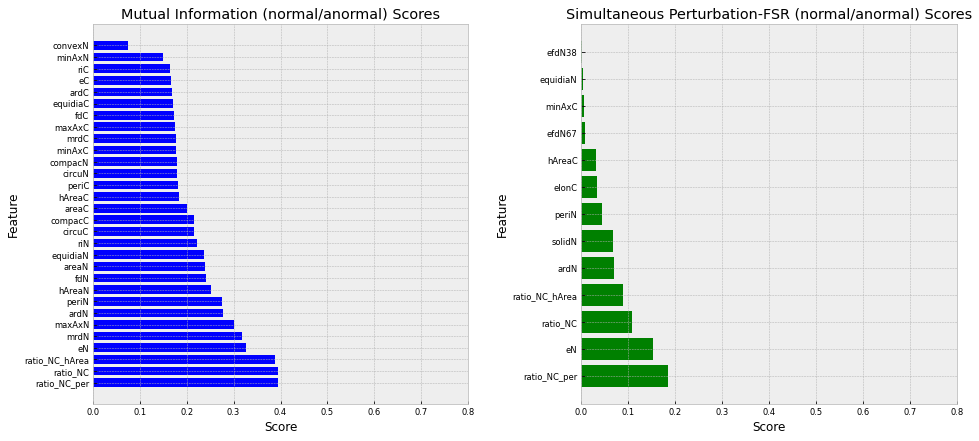

In [39]:
#best_features_spfsr
plot_imp(best_features_MI_1, feature_importances_MI_1, 'Mutual Information (normal/anormal)', 
         best_features_spfsr_1, feature_importances_spfsr_1, 'Simultaneous Perturbation-FSR (normal/anormal)') # 

In [228]:
#### Seleção de características:  classificador 2 (baixo/alto grau)   

In [40]:
best_features_spfsr_2, feature_importances_spfsr_2 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=2), N_FEATURES = None)
best_features_MI_2, feature_importances_MI_2 = features_selection_mi(*filter_dataXY(X_train, y_train, cls_type=2),
                                                                     features, N_FEATURES = N_FEATURES)

SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
SpFSR-INFO: Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 1896
SpFSR-INFO: Number of observations used: 1896
SpFSR-INFO: Number of features available: 200
SpFSR-INFO: Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_ft: 7, value: 0.972, st_dev: 0.008, best: 0.972 @ iter_no 0
SpFSR-INFO: iter_no: 10, num_ft: 20, value: 0.973, st_dev: 0.009, best: 0.974 @ iter_no 6
SpFSR-INFO: iter_no: 20, num_ft: 31, value: 0.972, st_dev: 0.005, best: 0.975 @ iter_no 12
SpFSR-INFO: iter_no: 30, num_ft: 30, value: 0.973, st_dev: 0.006, best: 0.975 @ iter_no 12
SpFSR-INFO: iter_no: 40, num_ft: 33, value: 0.972, st_dev: 0.008, best: 0.976 @ iter_no 34
SpFSR-INFO: iter_no: 50, num_ft: 31, value: 0.972, st_dev:

In [229]:
#### Seleção de características:  classificador 3 (ASC-US/LSIl)   

In [41]:
best_features_spfsr_3, feature_importances_spfsr_3 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=3), N_FEATURES = None)
best_features_MI_3, feature_importances_MI_3 = features_selection_mi(*filter_dataXY(X_train, y_train, cls_type=3),
                                                                     features, N_FEATURES = N_FEATURES)

SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
SpFSR-INFO: Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 713
SpFSR-INFO: Number of observations used: 713
SpFSR-INFO: Number of features available: 200
SpFSR-INFO: Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_ft: 2, value: 0.6, st_dev: 0.036, best: 0.6 @ iter_no 0
SpFSR-INFO: iter_no: 10, num_ft: 11, value: 0.619, st_dev: 0.04, best: 0.646 @ iter_no 8
SpFSR-INFO: iter_no: 20, num_ft: 12, value: 0.639, st_dev: 0.043, best: 0.647 @ iter_no 18
SpFSR-INFO: iter_no: 30, num_ft: 29, value: 0.626, st_dev: 0.021, best: 0.647 @ iter_no 18
SpFSR-INFO: iter_no: 40, num_ft: 32, value: 0.62, st_dev: 0.039, best: 0.647 @ iter_no 18
SpFSR-INFO: iter_no: 50, num_ft: 37, value: 0.628, st_dev: 0.035, 

In [231]:
#### Seleção de características:  classificador 4 (ASC-H/HSIl/Car)   

In [42]:
best_features_spfsr_4, feature_importances_spfsr_4 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=4), N_FEATURES = None)
best_features_MI_4, feature_importances_MI_4 = features_selection_mi(*filter_dataXY(X_train, y_train, cls_type=4),
                                                                     features, N_FEATURES = N_FEATURES)

SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
SpFSR-INFO: Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 1183
SpFSR-INFO: Number of observations used: 1183
SpFSR-INFO: Number of features available: 200
SpFSR-INFO: Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_ft: 4, value: 0.61, st_dev: 0.028, best: 0.61 @ iter_no 0
SpFSR-INFO: iter_no: 10, num_ft: 14, value: 0.631, st_dev: 0.026, best: 0.641 @ iter_no 8
SpFSR-INFO: iter_no: 20, num_ft: 17, value: 0.64, st_dev: 0.022, best: 0.645 @ iter_no 16
SpFSR-INFO: iter_no: 30, num_ft: 22, value: 0.627, st_dev: 0.024, best: 0.645 @ iter_no 16
SpFSR-INFO: iter_no: 40, num_ft: 23, value: 0.624, st_dev: 0.022, best: 0.645 @ iter_no 16
SpFSR-INFO: iter_no: 50, num_ft: 28, value: 0.637, st_dev: 0.

#### Funções tuning/gridsearch (SVM, RF, XGBoost)

In [101]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

def grid_search_SVM(model, params, X, y):
    grid_search = GridSearchCV(
        model, params, scoring= ['accuracy', 'f1_weighted'], refit='f1_weighted'
    )
    grid_search.fit(X, y)
    y_pred = grid_search.predict(X)
    print(classification_report(y, y_pred))
    return (grid_search.best_params_)

def grid_search_RF(model, params, X, y):
    grid_search = GridSearchCV(model, param_grid = params, 
        scoring= 'accuracy')
    grid_search.fit(X, y)
    y_pred = grid_search.predict(X)
    print(classification_report(y, y_pred))
    return (grid_search.best_params_)

def grid_search_XGB(model, params, X, y):
    folds = 5
    param_comb = 50
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
    
    random_search = RandomizedSearchCV(model, param_distributions= params,
                        n_iter=param_comb, scoring='accuracy', n_jobs=-1, 
                        cv=skf.split(X,y), random_state=1001)

    # Here we go
    start_time = timer(None) # Tempo inicial
    random_search.fit(X, y)
    timer(start_time)
    
    print('\n Best estimator:')
    print(random_search.best_estimator_)
    print('\n Best score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
    print(random_search.best_score_ )
    results = pd.DataFrame(random_search.cv_results_) 
    
    return random_search.best_params_, results
    

#### Tuning de parâmetros (Classificador) 
Feito para cada um dos métodos (SVM, RF e XGBOOST). 
Conjunto de dados para tuning:
   X: merge de todas as features selecionadas para o classificador hierarquico (features selecionadas acima de 1 à 4) 
   y: classificação em 6 classes bethesda.

In [49]:
features_sel = list(set(best_features_spfsr_1.tolist() + best_features_spfsr_2.tolist() +
                        best_features_spfsr_3.tolist() + best_features_spfsr_4.tolist()))
len(features_sel), #features_sel 

(75,)

In [99]:
svm_params = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "degree":[2,3,4], "gamma": [1e-3, 1e-4], "coef0":[2e-1, 2e-2] , "C": [1, 10, 100, 1000]},
]
svm_param =  grid_search_SVM(SVC(), svm_params, X_train[features_sel], y_train['bethesda'])
print('Best svm params: ', svm_param)

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       690
         1.0       0.67      0.31      0.42       242
         2.0       0.63      0.50      0.56       429
         3.0       0.71      0.89      0.79       471
         4.0       0.71      0.84      0.77       690
         5.0       1.00      0.59      0.75        64

    accuracy                           0.76      2586
   macro avg       0.78      0.68      0.70      2586
weighted avg       0.76      0.76      0.75      2586

Best svm params:  {'C': 100, 'kernel': 'linear'}


In [100]:
rf_params = {'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [10, 50, 100, 150]
            }
rf_param = grid_search_RF(RandomForestClassifier(random_state=0),
                             rf_params, X_train[features_sel], y_train['bethesda'])
print('Best Random Forest params: ', rf_param)

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       690
         1.0       0.93      0.27      0.42       242
         2.0       0.79      0.69      0.74       429
         3.0       0.71      0.98      0.82       471
         4.0       0.81      0.94      0.87       690
         5.0       1.00      0.48      0.65        64

    accuracy                           0.83      2586
   macro avg       0.87      0.72      0.74      2586
weighted avg       0.85      0.83      0.81      2586

Best Random Forest params:  {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 100}


In [94]:
xgb_params = {
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0, 0.3, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 7]
        }


xgb_param, result = grid_search_XGB(xgb.XGBClassifier(learning_rate=0.2, 
                                               n_estimators=100, objective='multi:softprob'),
                                    xgb_params, X_train[features_sel], y_train['bethesda'])
print('Best XGBoost params: ', xgb_param)                


 Time taken: 0 hours 1 minutes and 22.98 seconds.

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=10,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

 Best score for 5-fold search with 5 parameter combinations:
0.7119101140377737
Best XGBoost params:  {'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 7, 'gamma': 0.3, 'colsample_bytree': 0.8}


### Classificadores e métricas

In [96]:
# Gera modelos 
def getModel(params, classifier = 'SVM', class_type = 'binary'):
    if classifier == 'SVM':
          model = SVC().set_params(**params)
    elif classifier == 'RF':
          model = RandomForestClassifier().set_params(**params)
    elif classifier == 'XGBoost':
        if class_type == 'binary':
            model = xgb.XGBClassifier(learning_rate=0.2, n_estimators=100, objective= 'binary:logistic',
                     scale_pos_weight=1, seed=27).set_params(**params)
        else:    # multiclass  
            model = xgb.XGBClassifier(learning_rate=0.2, n_estimators=100, objective= 'multi:softprob',
                     scale_pos_weight=1, seed=27).set_params(**params) 
    else:
        model = None # 'MLP toDo'    
    return model    
    

# Calcula métricas: (vide metrics_type e classifiers_type)
def calc_metric(target_test, target_predict, metric_type='acc', class_type ='binary', pos_label=1, classes=[0,1]):   
    if (metric_type == 'acc'):
        return accuracy_score(target_test, target_predict)
    elif (metric_type == 'prec'):
         if (class_type == 'binary'):  ## caso classificadores binário
            return  precision_score(target_test, target_predict, pos_label= pos_label, zero_division=0)  
         else:  ## multiclasses
            return precision_score(target_test, target_predict, average='weighted', zero_division=0)
    elif (metric_type == 'rec'):
        if (class_type == 'binary'):  ## classificadores binários
            return recall_score(target_test, target_predict, pos_label= pos_label, zero_division=0)
        else:  ## multiclasses
            return  recall_score(target_test, target_predict, average ='weighted', zero_division=0)
    elif (metric_type == 'spec'):   
         if (class_type == 'binary'):  ## classificadores binários
            tn, fp, fn, tp = confusion_matrix(target_test, target_predict).ravel()
            return tn/(tn + fp)
         else:  ##  multiclasses - média aritmética  
            spec = 0
            for l in classes:
                tn, fp, fn, tp = confusion_matrix((np.array(target_test)==l), (np.array(target_predict)==l)).ravel()
                spec += tn/(tn + fp)
            return spec/len(classes)  
    elif (metric_type == 'f1_score'):      
         if (class_type == 'binary'):  ## classificadores binários
            f1 = f1_score(target_test, target_predict, pos_label= pos_label)
            return f1
         else:  ## multiclasses
            f1 = f1_score(target_test, target_predict, average= 'weighted')
            return f1 
    else:
        return None


def fill_line_metrics_CV(model_name, featur, line_results, metrics, results, class_type='binary'):
    line = pd.Series(data = np.array([class_type, model_name, featur,
             '{:.4f}'.format(metrics['acc']), '{:.4f}'.format(metrics['prec']),
             '{:.4f}'.format(metrics['rec']),'{:.4f}'.format((1- metrics['spec'])), 
             '{:.4f}'.format(metrics['spec']), '{:.4f}'.format(metrics['f1_score'])], dtype = object), 
              index=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 
                     'Falso Pos', 'Especif', 'F1_measure']) 
    results.loc[line_results] = line
    
    
def plot_roc_curve(roc_curve_list, labels_list):
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "deeppink", "navy", "darkorange"])
    plt.style.use("bmh")
    for i,color in zip(range(len(roc_curve_list)), colors):
        plt.plot(
            roc_curve_list[i][0],
            roc_curve_list[i][1],
            color=color,
            lw=2,
            label= labels_list[i],
        )
    plt.plot([0, 1] , c=".7", ls="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Normal vs anormal Random Forest) ')
    plt.legend(fontsize= 'medium')
    plt.show()
 
# Gera grafico matriz confusao  
def make_confusionMatrixDisplay(test, pred, labels, title):
    cm = confusion_matrix(test, pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    return (disp, title)


In [129]:
## Para Cross validation nos dados de teste e tuning de modelo (retorna métrica de treino)
def fit_model(X, y, model, cls_type= 1, cv=None):
    """
    Cria folds e upsamples dentro de cada fold.
    Returns array de métricas de validação
    """
    N_SPLITS = 10
    if cv is None:
        cv = StratifiedKFold(n_splits=10, random_state=None)

    smoter = SMOTE(random_state=42)
    accs = precs = recs = specs = f1_scores = aucs = np.zeros((N_SPLITS), dtype = np.float64)
    
    for i, (train_fold_index, val_fold_index) in enumerate(cv.split(X, y)):
        print(train_fold_index, val_fold_index)
        # Dados de treinamento
        X_train_fold, y_train_fold = X[train_fold_index], y[train_fold_index]
        # Dados de validação
        X_val_fold, y_val_fold = X[val_fold_index], y[val_fold_index]

        # Upsample apenas nos dados de treinamento
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
                                                                           y_train_fold)
        # Ajusta parâmetros:
        #if params == None:
            ### fazer aqui?
        model = model.fit(X_train_fold_upsample, y_train_fold_upsample)            
         
        # Predição:
        pred_y = model.predict(X_val_fold)
    
        if cls_type == 1:  ## normal/anormal
            cls = [0,1]
            class_type = 'binary'
            label = 1
        elif cls_type == 2:   ## baixo/alto grau
            cls = [1,2]
            class_type = 'binary'
            label = 2
        elif cls_type == 3:  ## asc-us/lsil
            cls = [1,3]
            class_type = 'binary'
            label = 3
        else:              ## asch/hsil/car
            cls = [2,4,5]
            class_type = 'ternary'
 
        # Calcula e registra métricas p/ fold:
        accs[i] = calc_metric(y_val_fold, pred_y, metric_type='acc', class_type = class_type, pos_label= label, classes=cls)
        precs[i] = calc_metric(y_val_fold, pred_y, metric_type='prec', class_type = class_type, pos_label= label, classes=cls)
        recs[i] = calc_metric(y_val_fold, pred_y, metric_type='rec', class_type = class_type, pos_label= label, classes=cls)
        specs[i] = calc_metric(y_val_fold, pred_y, metric_type='spec', class_type = class_type, pos_label= label, classes=cls)
        f1_scores[i] = calc_metric(y_val_fold, pred_y, metric_type='f1_score', class_type = class_type, pos_label= label, classes=cls)
       
    ## Registra resultados (dataframe):
    metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
                   'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}      
    return metrics, model

## 
 

### Treino classificador 1 (normal/anormal):

In [106]:
svm_model = getModel(svm_param, classifier = 'SVM', class_type = 'binary')
rf_model = getModel(rf_param, classifier = 'RF', class_type = 'binary')   
xgb_model = getModel(xgb_param, classifier = 'XGBOOST', class_type = 'binary')   
 

In [121]:
# Data_frame de resultados
classifiers = ['SVM', 'RF', 'XGBoost']
params = [svm_param, rf_param, xgb_param]
results = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
features_desc= " features N/C selected (normal/anormal)"  

lin= 0  ## linha inicial para inclusão no dataframe results
ci = 0
binaryModels = []
X_t, y_t =  filter_dataXY(X_test[best_features_spfsr_1], y_test, cls_type=1)

In [146]:
fit_model(svm_model,X_t.values, y_t.values, cls_type= 1)
#cv = StratifiedKFold(n_splits=10, random_state=None)
#for i, (train_fold_index, val_fold_index) in enumerate(cv.split(X_t, y_t)):
##    print(i, val_fold_index)
#    print(X_t.iloc[val_fold_index])
#    break
      

X_t.shape, y_t.shape


TypeError: Singleton array array(SVC(C=100, kernel='linear'), dtype=object) cannot be considered a valid collection.

KeyError: 1

In [204]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []  
mean_fpr = np.linspace(0, 1, 100)

for i in range(3):   
    ## Obtem modelo
    model = getModel(params= params[i], classifier = classifiers[ci], class_type = 'binary')
     
    # Predição:
    pred_y = model.predict(X_t)
    prob_y = model.predict_proba(X_t)
    
    # Calcula e registra métricas p/ fold:
    accs[i] = calc_metric(y_t, pred_y, metric_type='acc', class_type='binary', pos_label=1, classes=[0,1])
    precs[i] = calc_metric(y_t, pred_y, metric_type='prec',class_type='binary')                
    recs[i] = calc_metric(y_t, pred_y, metric_type='rec',class_type='binary')                
    specs[i] = calc_metric(y_t, pred_y, metric_type='spec',class_type='binary')                
    f1_scores[i] = calc_metric(y_t, pred_y, metric_type='f1_score',class_type='binary')                
       
    # Calcula curva_roc e AUC:
    prob = prob_y[:, 1]
    fpr, tpr, thresholds = roc_curve(data_y[test], prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs[i]= auc(mean_fpr, interp_tpr)
    roc_curve_list.append((mean_fpr, interp_tpr)) 
    label = r"ROC Curve (AUC %s= %0.4f)" % ((classifiers[ci]+"- normal/anormal"), aucs[i])
    labels_list.append(label)
    
    ## Registra resultados (dataframe):
    metrics = {'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
             'spec': specs[i], 'f1_score': f1_scores[i]}                                      
    fill_line_metrics_CV(classifiers[ci], features_desc, lin, metrics, results, class_type='1- Normal/Anormal')
   
    # Acumula Matrizes de confusão:
    conf_matrix_list.append(make_confusionMatrixDisplay(
    y_t, preds_y, labels = [0,1], title=features_desc + " - "+classifiers[ci]))

    lin+= 1
    ci+= 1                     

# Exibe curva ROC para classificador Binário (cross validation)
def plot_roc_curve_CV(roc_curve_list, labels_list, title = "ROC Curve - Normal vs Anormal"):
    fig, ax = plt.subplots(figsize=(9,5))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "deeppink", "navy", "darkorange"])
    plt.style.use("bmh")
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    for i,color in zip(range(len(roc_curve_list)), colors):
        ax.plot(
            roc_curve_list[i][0],
            roc_curve_list[i][1],
            color=color,
            label=labels_list[i],
            lw=2,
            alpha=0.8,
        )
 
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title= title
    )
    ax.legend(loc="lower right")
    plt.show()



In [205]:
len(labels_list), len(roc_curve_list), len(conf_matrix_list)

(3, 3, 3)

### Resultados:

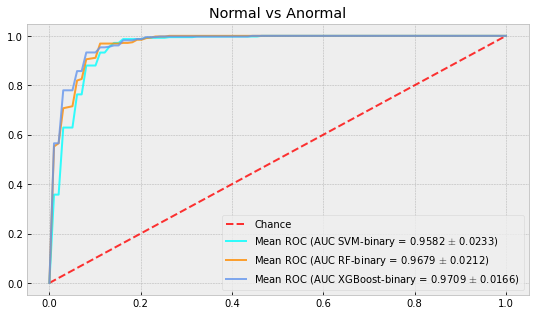

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,binary,SVM,30 features selected by MI,0.9582,0.9582,0.9582,0.0418,0.9582,0.9582
1,binary,RF,30 features selected by MI,0.9679,0.9679,0.9679,0.0321,0.9679,0.9679
2,binary,XGBoost,30 features selected by MI,0.9709,0.9709,0.9709,0.0291,0.9709,0.9709


In [206]:
plot_roc_curve_CV(roc_curve_list, labels_list, title = "Normal vs Anormal")
results


#### Matrizes de confução

<Figure size 432x288 with 0 Axes>

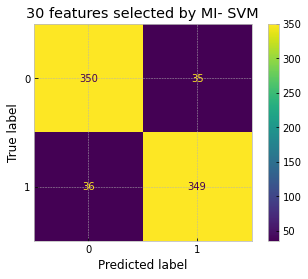

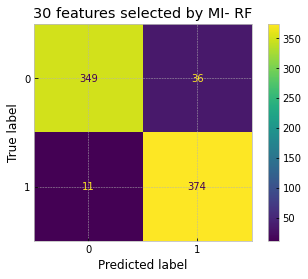

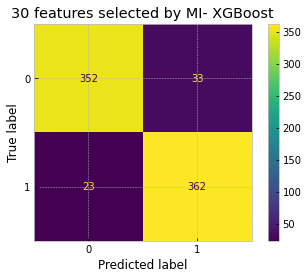

<Figure size 432x288 with 0 Axes>

In [207]:
#%matplotlib inline    

plt.figure(figsize=(6, 4))   #tupla para tamanho da figura (largura, altura)

for i in range(len(conf_matrix_list)):
    conf_matrix_list[i][0].plot()
    plt.title(conf_matrix_list[i][1])

plt.show()
plt.tight_layout()    #inclui espaçamento entre os gráficos

### Classificador ternário

In [621]:
# Melhor parâmetro:
best_param= sorted(score_tracker, key=lambda x: x['recall'], reverse=True)[0]
best_param

{'n_estimators': 200,
 'max_depth': 13,
 'random_state': 13,
 'recall': 0.9732433158202068}

In [622]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# Data_frame de resultados
results = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
lin= 0  ## linha inicial para inclusão no dataframe results
classifiers = ['SVM', 'RF', 'XGBoost']
ci = 0

In [625]:
## Treinamento e predição (Ternário):
features_desc= str(N_FEATURES)+" features selected"  
#tprs = []
#mean_fpr = np.linspace(0, 1, 100)

model = getModel(classifier = classifiers[ci], class_type = 'multiclass')  
metrics, model = score_model(model, best_param if ci==1 else None, type= 'ternary', cv=None)
print('metricas treino: ',metrics)

# Predição:
pred_y = model.predict(X_test) 
prob_y = model.predict_proba(X_test)
    
# Calcula e registra métricas p/ fold:
accs = calc_metric(y_test['ternary'], pred_y, metric_type='acc', class_type = 'multiclass', classes=[0,1,2])
precs  = calc_metric(y_test['ternary'], pred_y, metric_type='prec', class_type = 'multiclass', classes=[0,1,2])                
recs  = calc_metric(y_test['ternary'], pred_y, metric_type='rec', class_type = 'multiclass', classes=[0,1,2])                
specs  = calc_metric(y_test['ternary'], pred_y, metric_type='spec', class_type = 'multiclass', classes=[0,1,2])                
f1_scores  = calc_metric(y_test['ternary'], pred_y, metric_type='f1_score', class_type = 'multiclass', classes=[0,1,2])                
       
## Registra resultados (dataframe):
metrics = {'acc': accs, 'prec': precs, 'rec': recs, 
           'spec': specs, 'f1_score': f1_scores}      

fill_line_metrics_CV(classifiers[ci], features_desc, lin, metrics, results, class_type= "ternary")

# Acumula Matrizes de confusão:
conf_matrix_list.append(make_confusionMatrixDisplay(
      y_test['ternary'], pred_y, labels = [0,1,2], title=features_desc + "- "+classifiers[ci]))

lin+= 1
ci+= 1                     

metricas treino:  {'acc': 0.9403600223743457, 'prec': 0.9403600223743457, 'rec': 0.9403600223743457, 'spec': 0.9403600223743457, 'f1_score': 0.9403600223743457}


In [626]:
 len(labels_list), len(roc_curve_list), len(conf_matrix_list)

(0, 0, 3)

In [627]:
#plot_roc_curve_CV(roc_curve_list, labels_list, title = "Normal vs ASC-US/LSIL vs ASC-H/HSIL/Car")
results


,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,ternary,SVM,30 features selected,0.9505,0.9508,0.9505,0.0243,0.9757,0.9506
1,ternary,RF,30 features selected,0.9521,0.9520,0.9521,0.0242,0.9758,0.9519
2,ternary,XGBoost,30 features selected,0.9490,0.9491,0.9490,0.0253,0.9747,0.9490


<Figure size 432x288 with 0 Axes>

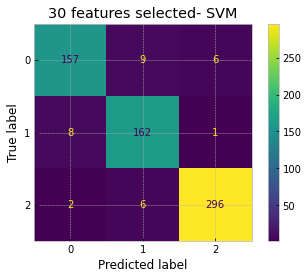

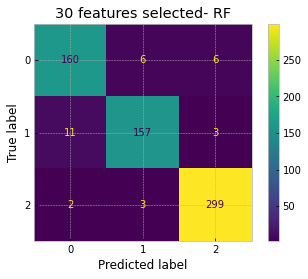

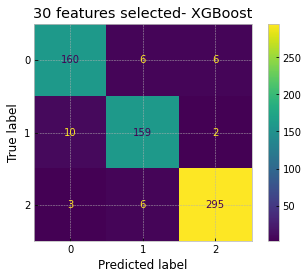

<Figure size 432x288 with 0 Axes>

In [628]:
#%matplotlib inline    

plt.figure(figsize=(6, 4))   #tupla para tamanho da figura (largura, altura)

for i in range(len(conf_matrix_list)):
    conf_matrix_list[i][0].plot()
    plt.title(conf_matrix_list[i][1])

plt.show()
plt.tight_layout()    #inclui espaçamento entre os gráficos

### Classificação Bethesda:

In [640]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# Data_frame de resultados
results = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
lin= 0  ## linha inicial para inclusão no dataframe results
classifiers = ['SVM', 'RF', 'XGBoost']
ci = 0

In [645]:
## Treinamento e predição (Ternário):
features_desc= str(N_FEATURES)+" features selected"  
#tprs = []
#mean_fpr = np.linspace(0, 1, 100)

model = getModel(classifier = classifiers[ci], class_type = 'multiclass')  
metrics, model = score_model(model, best_param if ci==1 else None, type= 'bethesda', cv=None)
print('metricas treino: ',metrics)

# Predição:
pred_y = model.predict(X_test) 
prob_y = model.predict_proba(X_test)
    
# Calcula e registra métricas p/ fold:
accs = calc_metric(y_test['bethesda'], pred_y, metric_type='acc', class_type = 'multiclass', classes=[0,1,2,3, 4, 5])
precs  = calc_metric(y_test['bethesda'], pred_y, metric_type='prec', class_type = 'multiclass', classes=[0,1,2, 3, 4, 5])                
recs  = calc_metric(y_test['bethesda'], pred_y, metric_type='rec', class_type = 'multiclass', classes=[0,1,2, 3, 4, 5])                
specs  = calc_metric(y_test['bethesda'], pred_y, metric_type='spec', class_type = 'multiclass', classes=[0,1,2, 3, 4, 5])                
f1_scores  = calc_metric(y_test['bethesda'], pred_y, metric_type='f1_score', class_type = 'multiclass', classes=[0,1,2, 3, 4, 5])                
       
## Registra resultados (dataframe):
metrics = {'acc': accs, 'prec': precs, 'rec': recs, 
           'spec': specs, 'f1_score': f1_scores}      

fill_line_metrics_CV(classifiers[ci], features_desc, lin, metrics, results, class_type= "ternary")

# Acumula Matrizes de confusão:
conf_matrix_list.append(make_confusionMatrixDisplay(
      y_test['bethesda'], pred_y, labels = [0,1,2, 3, 4, 5], title=features_desc + "- "+classifiers[ci]))

lin+= 1
ci+= 1                     

metricas treino:  {'acc': 0.6671924246661958, 'prec': 0.6671924246661958, 'rec': 0.6671924246661958, 'spec': 0.6671924246661958, 'f1_score': 0.6671924246661958}


In [646]:
 len(labels_list), len(roc_curve_list), len(conf_matrix_list)

(0, 0, 3)

In [648]:
results

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,ternary,SVM,30 features selected,0.6708,0.7131,0.6708,0.0655,0.9345,0.6857
1,ternary,RF,30 features selected,0.7048,0.7166,0.7048,0.0602,0.9398,0.7093
2,ternary,XGBoost,30 features selected,0.7233,0.7253,0.7233,0.0568,0.9432,0.7237


<Figure size 432x288 with 0 Axes>

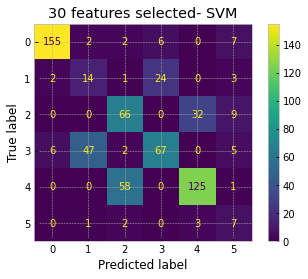

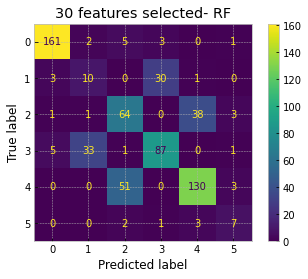

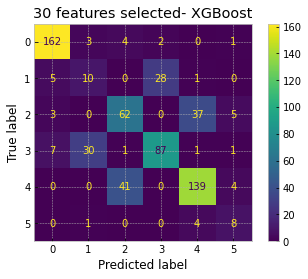

<Figure size 432x288 with 0 Axes>

In [637]:
#%matplotlib inline    

plt.figure(figsize=(6, 4))   #tupla para tamanho da figura (largura, altura)

for i in range(len(conf_matrix_list)):
    conf_matrix_list[i][0].plot()
    plt.title(conf_matrix_list[i][1])

plt.show()
plt.tight_layout()    #inclui espaçamento entre os gráficos

In [ ]:
# Exibe gráficos boxplot - dist nucleo borda:
fig = plt.figure(figsize =(15, 10))
ax = fig.add_subplot(111)

dist = []
num_samples = 77
for i in Bethesda_idx_classes.keys():
      dist.append(data_x[(0 + i*num_samples):((i+1)*num_samples), 14])

ax.boxplot(dist_to_C_border_cells, labels = ['Normal', 'ASC-US', 'ASC-H', 'LSIL','HSIL', 'Invasive Carcinoma'], patch_artist = True,
                notch ='True') 
ax.set_title("Proximidade do Núcleo da borda (citoplasma)")